## boilerplate

In [1]:
%matplotlib notebook

import os
import glob
import math
from scipy.misc import imread, imresize
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

## CNN creation

In [2]:
# activation function
def relu(x):
    return (tf.nn.relu(x) - 0.399) * 1.713

# convolutional layer
def convolution(x, f_out=None, w=3, activation=relu):
    f_in = x.get_shape().as_list()[3]
    if f_out is None:
        f_out = f_in

    F_init = tf.random_normal([w, w, f_in, f_out], 
                              stddev=1 / math.sqrt(w * w * f_in))

    F = tf.Variable(F_init, dtype=tf.float32)
    x = tf.nn.conv2d(x, F, [1, 1, 1, 1], 'SAME')
    
    b = tf.Variable(tf.constant(0, shape=[f_out], dtype=tf.float32))
    return activation(x + b) if activation else x + b

In [3]:
height, width = None, None # accept any image size

_input = tf.placeholder(tf.float32, [None, height, width, 3], name="input")

x = (_input - 0.59) / 0.32 # normalize
x = convolution(x, 16)
x = convolution(x, 32)
x = convolution(x, 64)
x = convolution(x, 32)
x = convolution(x, 16)
x = convolution(x, 3, activation=None)

_output = _input + x

_target = tf.placeholder(tf.float32, [None, height, width, 3], name="target")

_cost = tf.reduce_mean(tf.square(_output - _target))

_training_step = tf.train.AdamOptimizer(1e-3).minimize(_cost)

## Training

### Training set

In [4]:
files = glob.glob('./GUFD/fixed_size/*.jpg')
len(files)

605

### Initialize randomly the parameters

In [5]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Train 

In [6]:
fig = plt.figure()

xs = []
ys = []

ref = imread(files[0], mode='RGB').astype(np.float32) / 255
ref_blurred = gaussian_filter(ref, (3, 3, 0))
ref_unblurred = []

def update_plot(i, cost):
    xs.append(i / len(files))
    ys.append(math.sqrt(cost))
    
    plt.figure(fig.number)
    plt.cla()
    plt.plot(xs[-400:], ys[-400:], 'r-')
    plt.xlabel('generation')
    plt.ylabel('cost (estimation over the batch)')
    fig.canvas.draw()
    
    if i % 600 == 0:
        ref_unblurred.append(sess.run(_output, feed_dict={_input: [ref_blurred]})[0])

<IPython.core.display.Javascript object>

In [7]:
batch_size = 3

for i in range(0, 20 * len(files), batch_size):
    
    # load 3 images randomly
    images = [imread(files[j], mode='RGB').astype(np.float32) / 255
             for j in np.random.choice(len(files), batch_size, replace=False)]
    
    # blur them with a gaussian filter with std = 3
    blurred = gaussian_filter(images, (0, 3, 3, 0))

    # make a gradient descent step
    _, cost = sess.run([_training_step, _cost], feed_dict={_input: blurred, _target: images})
    
    update_plot(i, cost)

<IPython.core.display.Javascript object>


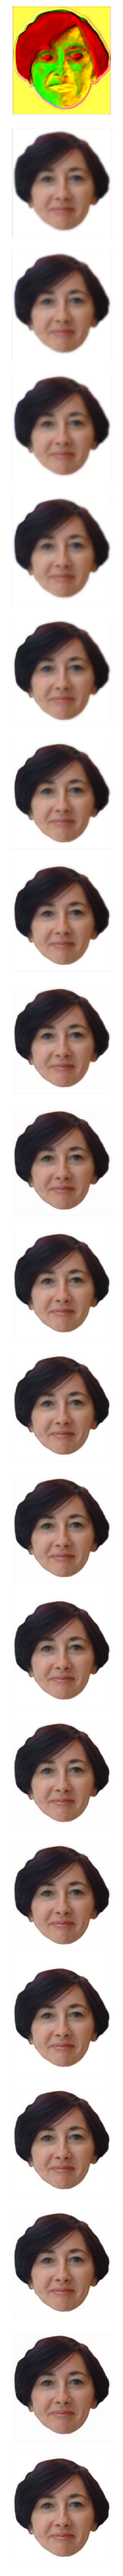

In [8]:
n = len(ref_unblurred)
_, axarr = plt.subplots(n, figsize=(4,4*n))
for i, image in enumerate(ref_unblurred):
    axarr[i].imshow(np.clip(image, 0, 1))
    axarr[i].axis('off')
    
plt.tight_layout()

## Results

In [9]:
def test(file):
    original = imresize(imread(file, mode='RGB'), (387, 350)).astype(np.float32) / 255

    blurred = gaussian_filter(original, (3, 3, 0))

    unblurred = sess.run(_output, feed_dict={_input: [blurred]})[0]
    
    fig = plt.figure()

    a = fig.add_subplot(1,2,1)
    a.imshow(np.clip(blurred, 0, 1))
    a.axis('off')

    a = fig.add_subplot(1,2,2)
    a.imshow(np.clip(unblurred, 0, 1))
    a.axis('off')

    plt.tight_layout()

In [10]:
test('obama.png')

<IPython.core.display.Javascript object>

In [11]:
test('woman1.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


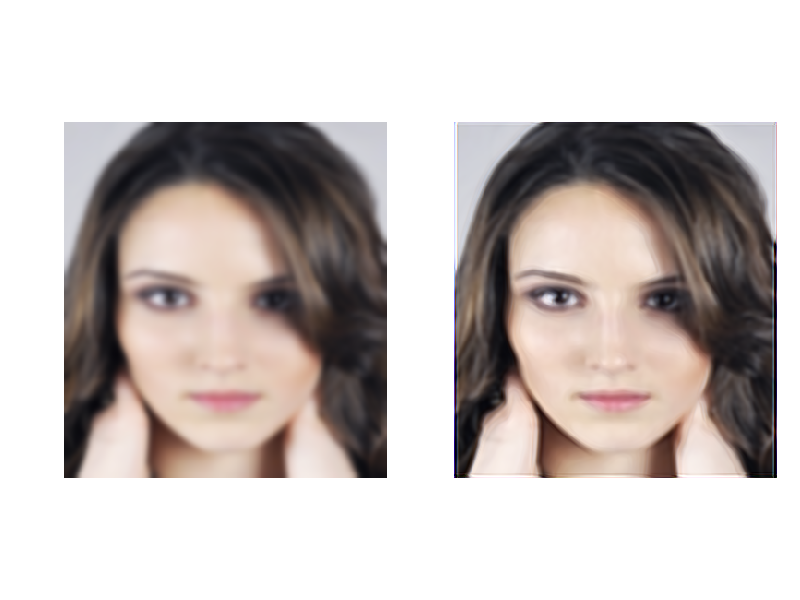

In [12]:
test('woman2.jpeg')